In [93]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [94]:
import numpy as np
import pandas as pd
import plotly.express as px

# Reflect Tables into SQLAlchemy ORM

In [95]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [96]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [97]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [98]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [99]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [100]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

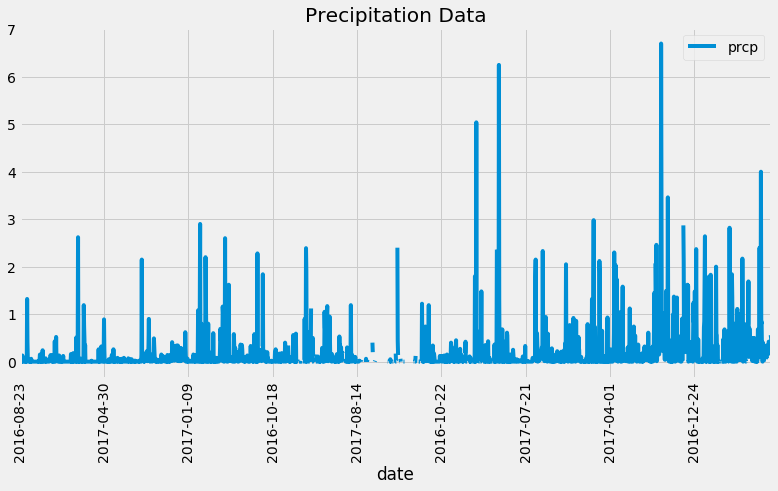

In [101]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
most_recent_date = session.query(func.max(Measurement.date)).first()[0]

most_recent_date = dt.datetime.strptime(most_recent_date, "%Y-%m-%d")

most_recent_year = int(dt.datetime.strftime(most_recent_date, "%Y"))

most_recent_month = int(dt.datetime.strftime(most_recent_date, "%m"))

most_recent_day = int(dt.datetime.strftime(most_recent_date, "%d"))
most_recent_date
most_recent_year
most_recent_month
most_recent_day
# Calculate the date 1 year ago from the last data point in the database
  #year_before = dt.datetime.strptime(most_recent_date, "%Y-%m-%d")-dt.timedelta(days=365)
prev_year = dt.date(most_recent_year, most_recent_month, most_recent_day)-dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
precp_data= session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= prev_year).all()
precp_data
# Save the query results as a Pandas DataFrame and set the index to the date column
precp_data_pd=pd.DataFrame(precp_data)
precp_data_pd.set_index("date", inplace=True)
# Sort the dataframe by date
precp_data_pd.sort_index(ascending=True)
# Use Pandas Plotting with Matplotlib to plot the data
precp_data_pd.plot(title="Precipitation Data", alpha=1, rot=90, figsize=(12,6))
plt.show()

In [102]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precp_data_pd.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [103]:
# Design a query to show how many stations are available in this dataset?
open_stations=session.query(func.count(Station.station)).all()
open_stations

[(9)]

In [104]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station)\
.order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [105]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
#determie and use the id with the most active station to aggregate/filter its rows & column. Hence:
temp_range=session.query(func.max(Measurement.tobs),func.min(Measurement.tobs),\
                         func.avg(Measurement.tobs)).filter(Measurement.station == "USC00519281").all()
temp_range

[(85.0, 54.0, 71.66378066378067)]

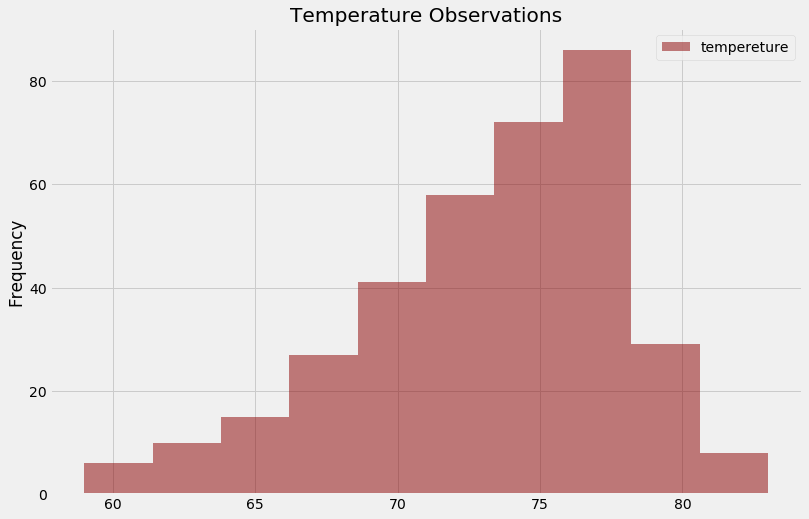

In [135]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
Highest_tempdata = session.query(Measurement.tobs).filter(Measurement.date >= prev_year).\
filter(Measurement.station == "USC00519281").all()
Highest_tempdata
Highest_tempdata_pd=pd.DataFrame(Highest_tempdata, columns=["tempereture"])
Highest_tempdata_pd.plot.hist(title="Temperature Observations", figsize=(12,8), bins=10, alpha=0.5, color="darkred") 
#Highest_tempdata_pd=Highest_tempdata_pd.sort_index(ascending=true)
#tips = px.data.tips()
#fig = px.histogram(tips, x="total_bill",nbins=12)
#fig.show

In [136]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [140]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
Trip_calc=calc_temps('2017-03-23', '2017-04-04')
Trip_calc

[(67.0, 74.5925925925926, 80.0)]

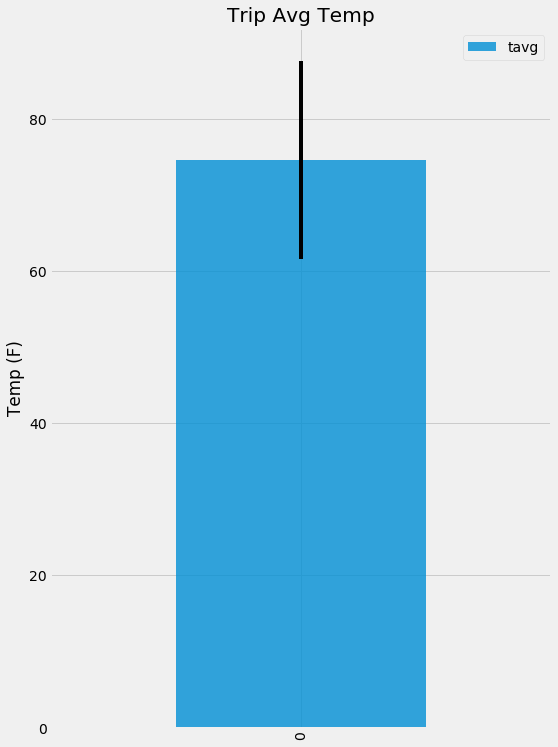

In [154]:
# Plot the results from your previous query as a bar chart. 
TMIN=67.0
TAVG=74.6
TMAX=80.0
columns=["tmin","tavg","tmax"]
Trip_calc_pd=pd.DataFrame(Trip_calc, columns=["tmin","tavg","tmax"])
# Use "Trip Avg Temp" as your Title
Trip_calc_pd.plot.bar(y="tavg", yerr=(Trip_calc_pd["tmax"] - Trip_calc_pd["tmin"]), alpha=0.8, title="Trip Avg Temp", figsize=(8,12))

# Use the average temperature for the y value
plt.ylabel("Temp (F)")
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.show()


In [159]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

#
        

def calc_temps(start_date, end_date):
    
    return session.query(func.min(Measurement.prcp), func.avg(Measurement.prcp), func.max(Measurement.prcp)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date)\
.group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


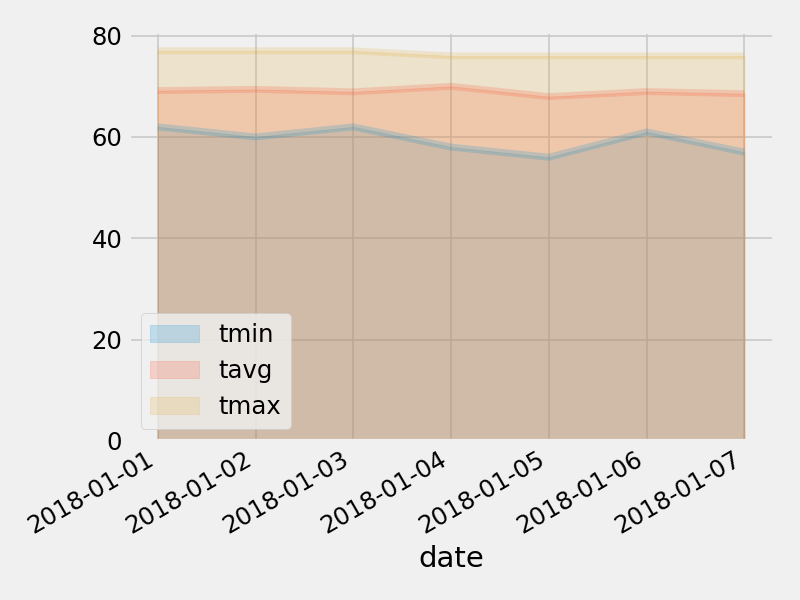

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
